# TensorFlow Similarity Self-Supervised Learning Hello World

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/unsupervised_hello_world.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/unsupervised_hello_world.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning and self-supervised learning quick and easy.

![self_supervised_overview.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/self_supervised_overview.png)

Self-supervised learning is an approach to pre-training models using unlabeled data. This approach drastically increases accuracy when you have very few labeled examples but a lot of unlabelled data. The key insight is that you can train a self-supervised model to learn data representations by contrasting multiple augmented views of the same example. These learned representations capture data invariants, e.g., object translation, color jitter, noise, etc. Training a simple linear classifier on top of the frozen representations is easier and requires fewer labels because the pre-trained model already produces meaningful and generally useful features. Overall, self-supervised pre-training learns representations which are more [generic](https://arxiv.org/abs/2110.00528) and [robust](https://arxiv.org/abs/1902.01889) than other approaches to augmented training and pre-training. 

Tensorflow Similarity provides a set of network architectures, losses, and data augmentations that are common across a number of self-supervised learning techniques. The Tensorflow Similarity package attempts to provide a consistent terminology across these techniques; however, this leads to slightly different naming conventions, as many papers use different terms to describe the same components. 

The main terms used by Tensorflow Similarity are:

* **View**: A view represents an augmented example.

* **Backbone**: Refers to the model that learns the **Representation** that we will use for downstream tasks.

* **Projector**: Is an MLP model that projects the backbone representation of a view to an **Embedding** that is contrasted with other views using a specialized contrastive loss.

* **Predictor**: Is an optional MLP model that is used, in conjunction with gradient stopping, in some recent architectures to further improve the representation quality.

* **Stop Gradient**: Is used by some algorithms to ensure that we only propagate the update from the main view and not the contrasting view.


![contrastive_model_terms.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_model_terms.png)


### Notebook goal

This notebook demonstrates how to use Tensorflow Similarity to boost classification accuracy by pre-training a ResNet18 model using contrastive learning on the cifar10 dataset. As you will see, the pre-trained model achieves about ~1.8x the accuracy of the model trained without pre-training. For example, **using SimSiam pre-training, you can achieve 87%-91% accuracy versus 50% accuracy when training the same architecture from scratch**.

To do this, this notebook walks through how to:

1. Create a `tf.data.Dataset` that will generate two augmented views for each example in a batch.

2. Create basic versions of **Backbone**, **Projector**, and **Predictor** networks to construct the `ContrastiveModel()`

3. Train a `ContrastiveModel()` using one of the following contrastive learning algorithms: [SimCLR](https://arxiv.org/abs/2002.05709), [SimSiam](https://arxiv.org/abs/2011.10566), and [Barlow Twins](https://arxiv.org/abs/2103.03230).

4. Compare the classification performance of the pre-trained model versus a model trained from scratch.


### Things to try

You can explore the following things that will affect the model performance:
- Try different self-supervised learning algorithms.
- Pre-train on a different dataset, e.g., cifar100.
- Restrict supervised training to use a subset of the data, e.g., 100 labels per class.
- Use a larger embedding by increasing the size of the projection and predictor layers.
- Try using different augmentation profiles.

In [1]:
import gc
import os
import random
import time
import mtcnn
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from math import floor
from tabulate import tabulate
from pathlib import Path
from os.path import join as path_join

# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1" # INFO messages are not printed.
os.environ["TF_GPU_ALLOCATOR"]= "cuda_malloc_async" # Won't explode the program if memory is not whole

import tensorflow as tf
import tensorflow_datasets as tfds

# Install TF similarity and addons if needed
try:
    import tensorflow_addons as tfa  # main package
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    os.system("pip install tensorflow tensorflow-addons tensorflow_similarity numpy pillow matplotlib mtcnn")
    import tensorflow_addons as tfa;
    import tensorflow_similarity as tfsim

# Import newly installed packages
import tensorflow_similarity.visualization as tfsim_visualization
import tensorflow_similarity.callbacks as tfsim_callbacks
import tensorflow_similarity.augmenters as tfsim_augmenters
import tensorflow_similarity.losses as tfsim_losses
import tensorflow_similarity.architectures as tfsim_architectures
from tensorflow.keras.utils import image_dataset_from_directory

2023-10-30 16:38:40.787601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 16:38:41.716345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/breno/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/breno/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libr

In [2]:
# Must have only folders of images (one per class)
TRAIN_PATH = path_join("training") 
TEST_PATH = path_join("validation") 

N_CLASSES = len(os.listdir(TRAIN_PATH))

RAND_SEED = 42

# Tuple with data split (train, validation, query, index)
DATA_SPLIT = (.5, .1, .2, .2)

# Image's input size (width, height)
INPUT_SIZE = (200, 200)

In [3]:
# Avoid GPU memory blow up
# tfsim.utils.tf_cap_memory()  

# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

# Disable the progress bar for predict 
# tf.keras.utils.disable_interactive_logging()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.13.0
TensorFlow Similarity 0.17.1


## Dataset Preperation

The following section:
* Loads the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) data from tensorflow datasets.
* Creates the train, val, test, and query/index splits.

In [4]:
DATA_PATH = Path("tfsim_contrastive_model")
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

### Load The Raw Data

We are going to load the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset. This dataset is often used in the self-supervised papers, enabling us to reproduce the published results. 

In [5]:
# If you want the CIFAR10 dataset, not this time.
# ((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
#     "cifar10",
#     split=["train", "test"],
#     batch_size=-1,
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True,
# )

In [6]:
# split_train_data()

# x_train, y_train = image_dataset_from_directory(TRAIN_PATH,
#                                              label_mode="int",
#                                              seed=RAND_SEED,
#                                              shuffle=True, 
#                                              batch_size=16, 
#                                              image_size=(300, 300))


# x_test, y_test = image_dataset_from_directory(TEST_PATH,
#                                              label_mode="int",
#                                              seed=RAND_SEED,
#                                              shuffle=True, 
#                                              batch_size=16, 
#                                              image_size=(300, 300))


In [7]:
# def assert_path(path) -> bool:
#     is_path = os.path.isdir(path)
#     if not is_path:
#         os.mkdir(path)
#     return is_path

# # Remove Smelly images
# whitelist = ("jpg", "jpeg", "png")
# trash_path = path_join(os.getcwd(), "img_trash")
# assert_path(trash_path)
# for root, paths, files in os.walk("training"):
#     for name in files:
#         filepath = os.path.join(root, name)
#         img_type = imghdr.what(filepath)
#         if img_type is None or img_type not in whitelist:
#             print(f"{filepath} is a smelly image")
#             os.rename(filepath, path_join(trash_path, name))


In [8]:
# We do this to not memory leak
def clear_oom():
    print("Clearing the Cache and running Garbage Collection")
    gc.collect()
    K.clear_session()

# # Crop all the images to fit just the faces
# for _class in os.listdir(TRAIN_PATH):
#     print(f"Class => {_class}")
#     # MTCNN face detector
#     detector = mtcnn.MTCNN()
#     clear_oom()
#     for img in os.listdir(path_join(TRAIN_PATH, _class)):
#         print(img)
#         # Load image and detect faces
#         pic = cv2.cvtColor(cv2.imread(path_join(TRAIN_PATH, _class, img)), cv2.COLOR_BGR2RGB)
#         roi = detector.detect_faces(pic)
        
#         # If there are no faces or more than one, discard the image
#         if not roi or len(roi) > 1:
#             os.rename(path_join(TRAIN_PATH, _class, img), path_join(trash_path, img))
#             continue

#         # Create a new picture cropping only the face
#         x1, y1, width, height = roi[0]["box"]
#         x2, y2 = x1 + width, y1 + height
#         # Resize to input into our model
#         resized = cv2.resize(pic[y1:y2, x1:x2], INPUT_SIZE, interpolation=cv2.INTER_LANCZOS4)
#         cv2.imwrite(path_join(TRAIN_PATH, _class, img), cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

# clear_oom()

In [9]:
# Load in the images and labels
labels = []
x_raw_train, y_raw_train = [],[]
for idx, _class in enumerate(os.listdir(TRAIN_PATH)):
    labels.append(_class)
    for img in os.listdir(path_join(TRAIN_PATH, _class)):
        pic = cv2.cvtColor(cv2.imread(path_join(TRAIN_PATH, _class, img)), cv2.COLOR_BGR2RGB)
        # Append the inputs
        x_raw_train.append(pic)
        y_raw_train.append(idx)

x_raw_train = np.asarray(x_raw_train)
y_raw_train = np.asarray(y_raw_train)

x_raw_train.shape, y_raw_train.shape

((2511, 400, 400, 3), (2511,))

### Create Data Splits
The TensorFlow Datasets' [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset provides a test and train split. 
* **Train**: Used for self-supervised pre-training and for training the classifiers.
* **Test**: Reserved for the classifier evaluation.

However, we are going to partition the train data into the following additional splits:

* **Validation**: Data used for validation metrics during the pre-training phase. 
* **Query and Index**: Data used to compute matching metrics. The query data is used to retrieve the nearest indexed examples.

In particular, the Query and Index split allows us to track the matching classification performance during training. 

<div class="alert alert-block alert-info"> <b>NOTE </b> An increasing match accuracy is a strong indication that the model is learning useful features, however, it does require that we have labeled data. If a dataset only has a small number of labeled examples, they can be passed as the query and index to help monitor the potential matching classification performance during training.</div> 


In [10]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(N_CLASSES):
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    idxs = tf.reshape(idxs, (-1,))
    leng = len(idxs)

    train = int(leng * DATA_SPLIT[0])  # Training Split
    train_idxs.extend(idxs[:train])
    
    val = int(leng * DATA_SPLIT[1]) + train # Validation Split 
    val_idxs.extend(idxs[train:val]) 

    query = int(leng * DATA_SPLIT[2]) + val # Query Split
    query_idxs.extend(idxs[val:query])

    index = int(leng * DATA_SPLIT[3]) + query # Index Split
    index_idxs.extend(idxs[query:])
    
    print(f"{cid} =>", train, val, query, index)

# Shuffle all the indexes to avoid bias
random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

2023-10-30 16:38:58.558924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-30 16:38:58.627003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-30 16:38:58.627076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-30 16:38:58.629445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-30 16:38:58.629581: I tensorflow/compile

0 => 147 176 234 292
1 => 222 266 354 442
2 => 200 240 320 400
3 => 176 211 281 351
4 => 144 172 229 286
5 => 157 188 250 312
6 => 208 249 332 415


In [11]:
def create_split(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])
    return tf.convert_to_tensor(np.array(x)), tf.convert_to_tensor(np.array(y))


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

2023-10-30 16:39:00.757230: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 239040000 exceeds 10% of free system memory.
2023-10-30 16:39:01.061059: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245280000 exceeds 10% of free system memory.
2023-10-30 16:39:02.260015: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 601920000 exceeds 10% of free system memory.


In [12]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
            # ["test", x_test.shape, y_test.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples             Labels
-----  -------------------  --------
train  (1254, 400, 400, 3)  (1254,)
val    (248, 400, 400, 3)   (248,)
query  (498, 400, 400, 3)   (498,)
index  (511, 400, 400, 3)   (511,)


## Self-Supervised Training Setup

This following section:
* Sets the training parameters used for building the different architectures.
* Creates a train and test tf.data.Dataset.
* Visualizes the pairs of augmented views from a single batch.

### Self-Supervised Algorithm Selection
[TensorFlow Similarity](https://github.com/tensorflow/similarity) currently supports three different self-supervised models.
* [SimCLR](http://arxiv.org/abs/2002.05709): Only requires the Backbone and the projector and uses a contrastive cross-entropy loss.
* [SimSiam](https://arxiv.org/abs/2011.10566): Requires the Backbone, projector, and predictor and only compares the cosine distance between augmented views from the same example.
* [Barlow Twins](https://arxiv.org/abs/2103.03230): Only requires the Backbone and the projector and uses a loss that compares the feature covariance instead of contrasting the views.
* [VicReg](https://arxiv.org/abs/2105.04906): Only requires the Backbone and projector and uses a loss that enforces the learned representations to be invariant to random augmentations while preserving the covariance and variance information.

The `ALGORITHM` parameter is used throughout this notebook to set up the various architectures and the parameters defined below are set up to reproduce the results published in the papers. 

In [13]:
ALGORITHM = "simsiam"  # @param ["barlow", "simsiam", "simclr", "vicreg"]

### Training Parameter Setup

In [14]:
IMG_SIZE = INPUT_SIZE[0]
BATCH_SIZE = 16
PRE_TRAIN_EPOCHS = 800
PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
VAL_STEPS_PER_EPOCH = 20
WEIGHT_DECAY = 5e-4
DIM = 512  # The layer size for the projector and predictor models.
WARMUP_LR = 0.0
WARMUP_STEPS = 0
TEMPERATURE = None

if ALGORITHM == "simsiam":
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
elif ALGORITHM == "barlow":
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_STEPS = 1000
elif ALGORITHM == "simclr":
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule, see section B.1 in the paper.
    TEMPERATURE = 0.5  # Tuned for CIFAR10, see section B.9 in the paper.
elif ALGORITHM == "vicreg":
    INIT_LR = 1e-3

### Augmented View Configuration

Self-supervised networks require at least two augmented "views" of each example. This can be created using a DataSet and an augmentation function. The DataSet treats each example in the batch as its own class and then the augment function produces two separate views for each example. 

This means the resulting batch will yield tuples containing the two views, i.e., `Tuple[(BATCH_SIZE, 32, 32, 3), (BATCH_SIZE, 32, 32, 3)]`. TODO make this clearer, "each example in the batch is of this type"

TensorFlow Similarity provides several random augmentation functions, and here we combine augmenters from the simCLR module to replicate the augmentations used in simsiam.

In [15]:
def img_scaling(img):
    return tf.keras.applications.imagenet_utils.preprocess_input(img, data_format=None, mode="torch")

# Apply a lot of bullshit filters to create an augmented version of an example in the batch
@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        img, IMG_SIZE, IMG_SIZE, area_range=area_range
    )

    # The following transforms expect the data to be [0, 1]
    img /= 255.0

    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "multiplicative",
        )

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_jitter_transform, p=0.8, x=img)

    # Random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.to_grayscale(x)

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.augmentation_utils.blur.random_blur(img, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)

    # scale the data back to [0, 255]
    img = img * 255.0
    img = tf.clip_by_value(img, 0.0, 255.0)

    return img


@tf.function()
def process(img):
    view1 = simsiam_augmenter(img, blur=False)
    view1 = img_scaling(view1)
    view2 = simsiam_augmenter(img, blur=False)
    view2 = img_scaling(view2)
    return (view1, view2)


train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

2023-10-30 16:39:02.820005: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 601920000 exceeds 10% of free system memory.


### Visualize Augmentations

The following cell plots the pairs of augmented views side by side. This can be a useful sanity check as many augmentation functions are set up for the larger ImageNet examples and can be overly aggressive for smaller images found in CIFAR.

2023-10-30 16:39:04.055896: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 601920000 exceeds 10% of free system memory.


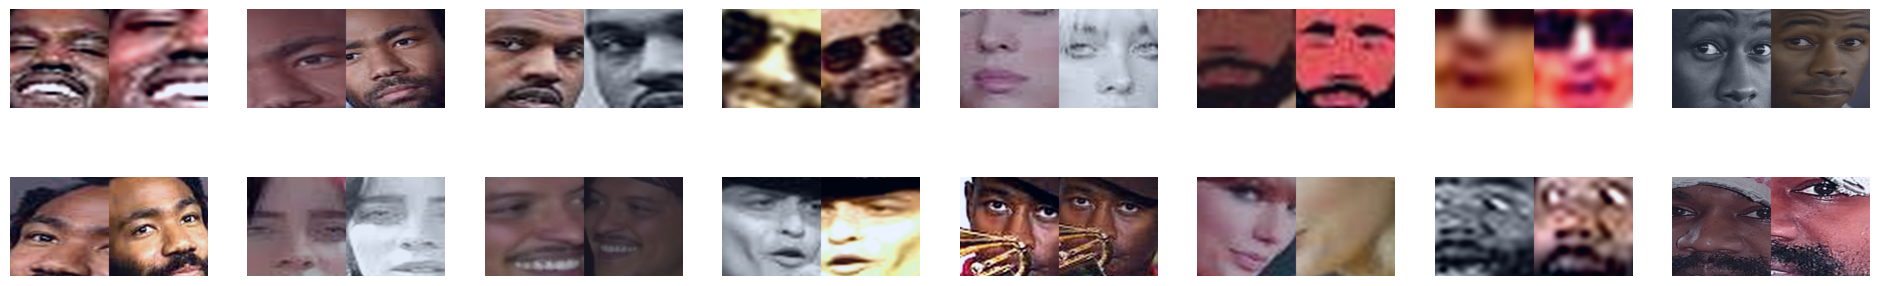

In [16]:
display_imgs = next(train_ds.as_numpy_iterator())
max_pixel = np.max([display_imgs[0].max(), display_imgs[1].max()])
min_pixel = np.min([display_imgs[0].min(), display_imgs[1].min()])

tfsim_visualization.visualize_views(
    views=display_imgs,
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

## Contrastive Model Setup
 
The following section creates the sub-models used by the different algorithms. There are various architectures for building self-supervised models which may include some of the following:
* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.
 
Typically, the projector and predictor networks are only 2 or 3 layers with batch normalization. While some [papers](https://arxiv.org/abs/2010.10241) claim that batch normalization is not required, the [SimSiam paper](https://arxiv.org/abs/2011.10566) shows empirically that the batch normalization is critical to prevent the model from collapsing to a degenerate solution.
 
Additionally, many papers show a single `encoder` block, but this often contains both the `Backbone` and the `Projector` network.
 
![contrastive_loss_functions.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_loss_functions.png)
 
The diagram above shows three self-supervised architectures supported by TensorFlow Similarity. As you can see, they all share a common structure:
* Processing multiple views of the same example.
* Using a backbone model for learning the representation output. 
* Using a projector for the embedding output.
* Additionally, note that the loss is symmetric, so we compute it twice during each step. First for view 1 and then a second time for view 2. These two losses are then summed up to compute the final aggregate loss.
 
However, there are some key differences including:
 
* The loss is different in each of the three architectures.
    * SimCLR uses a contrastive cross-entropy loss where each example's pair of augmented views should be close to 1 and all other views should be close to zero. Including the negative examples in the loss is part of the reason that SimCLR benefits from larger batch sizes.
    * SimSiam only compares the cosine distance between the pairs of augmented views. This means there are no negative examples in the loss, and consequently, the batch size can be much smaller.
    * Barlow Twins attempts to learn the cross-correlation between the embedding features, where similar feature activations between two views will produce small values along the diagonal and a positive penalty is applied for positive or negative off-diagonal correlations. In this way the diagonal represents features that are invariant to augmented views, while the off-diagonal values encourage the features to be independent of each other.
* The SimSiam architecture requires an additional Predictor network.
* The SimSiam architecture also uses a stop-gradient to ensure that we only flow the gradient from the target view.
 
 
TensorFlow Similarity offers a common set of modules to construct the common parts, and implement the parts which are specific to popular self-supervised algorithms on top of it. Attempting to offer flexibility to add your own algorithm or reuse proven architectures that the results we have reproduced. 

### Backbone Model

The backbone uses a custom version of ResNet18 in order to reproduce the SimSiam CIFAR10 results.
 
<div class="alert alert-block alert-info"> <b>NOTE</b> The ResNet models provided in `tf.keras.applications` use larger `[(1x1), (3x3), (1x1)]` blocks that can't be used to reproduce the SimSiam CIFAR10 results. </div>

In [17]:
def get_backbone(img_size, activation="relu", preproc_mode="torch"):
    input_shape = (img_size, img_size, 3)

    backbone = tfsim_architectures.ResNet18Sim(
        input_shape,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",
    )
    return backbone


backbone = get_backbone(IMG_SIZE)
backbone.summary()

Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 resnet18 (Functional)       (None, 50, 50, 512)       11182784  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 512)               0         
 ling2D)                                                         
                                                                 
Total params: 11182784 (42.66 MB)
Trainable params: 11173056 (42.62 MB)
Non-trainable params: 9728 (38.00 KB)
_________________________________________________________________


### Projector Model
 
This MLP is common to all the self-supervised models and is typically a stack of 3 layers of the same size. However, SimSiam only uses 2 layers for the smaller CIFAR images. Having too much capacity in the models can make it difficult for the loss to stabilize and converge.
 
Additionally, the SimSiam paper found that disabling the center and scale parameters can lead to a small boost in the final loss.
 
<div class="alert alert-block alert-info"> <b>NOTE</b> This is the model output that is returned by `ContrastiveModel.predict()` and represents the distance based embedding. This embedding can be used for the KNN lookups and matching classification metrics. However, when using the pre-train model for downstream tasks, only the `ContrastiveModel.backbone` is used. </div>

In [18]:
projector = None  # Passing None will automatically build the default projector.

# # Uncomment to build a custom projector.
# def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
#     inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
#     x = inputs

#     for i in range(num_layers - 1):
#         x = tf.keras.layers.Dense(
#             dim,
#             use_bias=False,
#             kernel_initializer=tf.keras.initializers.LecunUniform(),
#             name=f"projector_layer_{i}",
#         )(x)
#         x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name=f"batch_normalization_{i}")(x)
#         x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(x)
#     x = tf.keras.layers.Dense(
#         dim,
#         use_bias=False,
#         kernel_initializer=tf.keras.initializers.LecunUniform(),
#         name="projector_output",
#     )(x)
#     x = tf.keras.layers.BatchNormalization(
#         epsilon=1.001e-5,
#         center=False,  # Page:5, Paragraph:2 of SimSiam paper
#         scale=False,  # Page:5, Paragraph:2 of SimSiam paper
#         name=f"batch_normalization_ouput",
#     )(x)
#     # Metric Logging layer. Monitors the std of the layer activations.
#     # Degnerate solutions colapse to 0 while valid solutions will move
#     # towards something like 0.0220. The actual number will depend on the layer size.
#     o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
#     projector = tf.keras.Model(inputs, o, name="projector")
#     return projector

# projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
# projector.summary()

### Predictor model

The predictor model is used by [BYOL](https://arxiv.org/abs/2006.07733) and [SimSiam](https://arxiv.org/abs/2011.10566), and is an additional 2 layer MLP containing a bottleneck in the hidden layer.

In [19]:
predictor = None  # Passing None will automatically build the default predictor.

# # Uncomment to build a custom predictor.
# def get_predictor(input_dim, hidden_dim=512, activation="relu"):
#     inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
#     x = inputs

#     x = tf.keras.layers.Dense(
#         hidden_dim,
#         use_bias=False,
#         kernel_initializer=tf.keras.initializers.LecunUniform(),
#         name="predictor_layer_0",
#     )(x)
#     x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name="batch_normalization_0")(x)
#     x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

#     x = tf.keras.layers.Dense(
#         input_dim,
#         kernel_initializer=tf.keras.initializers.LecunUniform(),
#         name="predictor_output",
#     )(x)
#     # Metric Logging layer. Monitors the std of the layer activations.
#     # Degnerate solutions colapse to 0 while valid solutions will move
#     # towards something like 0.0220. The actual number will depend on the layer size.
#     o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
#     predictor = tf.keras.Model(inputs, o, name="predictor")
#     return predictor


# predictor = get_predictor(input_dim=DIM, hidden_dim=512)
# predictor.summary()

## Self-Supervised Algorithms
 
The following section builds the `ContrastiveModel` based on the `ALGORITHM` set at the start of the Notebook.
 
The model training is very sensitive to the learning rate decay and weight decay.
* **SimSiam**: Requires using SGD with weight decay from TF Addons. Adding weight decay as a kernel_regularizer doesn't seem to be able to reproduce the published results in the paper.
* **Barlow Twins**: We can use LAMB and avoid the need for the learning rate schedule. Lamb is similar to the LARS optimizer used in the Barlow paper, but includes the use of ADAM. Alternatively, we can use SGD but the optimizer requires a warm up period, otherwise the loss explodes.
* **SimCLR**: We can also use LAMB as the original paper uses LARS. However, LAMB seems to require smaller learning rates than shown for LARS in the original paper.

In [20]:
contrastive_model = tfsim.models.create_contrastive_model(
    backbone=backbone,
    projector=projector,
    predictor=predictor,
    algorithm=ALGORITHM,
    name=ALGORITHM,
)

if ALGORITHM == "simsiam":
    loss = tfsim_losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=WEIGHT_DECAY,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tfa.optimizers.SGDW(learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9)
elif ALGORITHM == "barlow":
    loss = tfsim_losses.Barlow(name=ALGORITHM)
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
elif ALGORITHM == "simclr":
    loss = tfsim_losses.SimCLRLoss(name=ALGORITHM, temperature=TEMPERATURE)
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
elif ALGORITHM == "vicreg":
    loss = tfsim_losses.VicReg(name=ALGORITHM)
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

### Compile

In [21]:
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

### Callbacks

We track the training using several callbacks.

* **EvalCallback** creates an index at the end of each epoch and provides a proxy for the nearest neighbor matching classification using `binary_accuracy`.
* **TensordBoard** and **ModelCheckpoint** are provided for tracking the training progress.

In [22]:
log_dir = DATA_PATH / "models" / "logs" / f"{loss.name}_{time.time()}"
chkpt_dir = DATA_PATH / "models" / "checkpoints" / f"{loss.name}_{time.time()}"

clear_oom()

evb = tfsim_callbacks.EvalCallback(
    img_scaling(tf.cast(x_query, tf.float32)),
    y_query,
    img_scaling(tf.cast(x_index, tf.float32)),
    y_index,
    metrics=["binary_accuracy"],
    k=1,
    tb_logdir=log_dir,
)
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
)
mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpt_dir,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

Clearing the Cache and running Garbage Collection
TensorBoard logging enable in tfsim_contrastive_model/models/logs/simsiam_1698694747.2595942/index


## Model Training
 
The model training provides a number of metrics.
- **loss**: This represents the total loss over the contrastive batch. Separate contrastive and regularization losses will also be shown if there are trainable variables in the model layers.
- **proj_std and pred_std**: These are added as metric logging layers in the model and show the std of the activations of the final layer in the projector or predictor models.
- **binary_accuracy**: This is the nearest neighbor matching classification accuracy. A new index is built at the end of each epoch and the accuracy is computed using the query and index examples.
 
**Notes: Move this to the evaluation section in the paper.**
- SGDW or LAMB seems to be required to prevent the loss from becoming unstable.
- Per layer kernel_regularization with weight decay doesn't work.
- The kernel initialization seems very critical. Smaller, uniform initialization schemes like Lecunn seem to work best.
- The projector is a more stable output for the KNN match metrics. The predictor output is typically worse and higher variance.
- The LR and weight decay schedule seem important. The loss becomes unstable if the updates are too large later in training.
- Too much capacity in the combined model and the training won't converge... same goes for too little capacity.
- Augmentation is critical, but too much augmentation and the model won't converge.

In [23]:
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[evb, tbc, mcp],
    verbose=1,
)

Epoch 1/800


2023-10-30 16:39:25.044974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-10-30 16:40:09.959945: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 655360000 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/4294836224
2023-10-30 16:40:09.960376: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      2867278644
InUse:                      7317136394
MaxInUse:                   7317137418
NumAllocs:                        3350
MaxAllocSize:                981120000
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-10-30 16:40:09.960998: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in

ResourceExhaustedError: Graph execution error:

Detected at node 'resnet18sim/resnet18/conv2_block1_0_conv/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/breno/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/breno/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/breno/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/breno/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/breno/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/breno/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/breno/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/breno/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/breno/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/breno/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/breno/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/breno/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/breno/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/breno/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/breno/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2789/467716841.py", line 1, in <module>
      history = contrastive_model.fit(
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/breno/.local/lib/python3.10/site-packages/tensorflow_similarity/models/contrastive_model.py", line 323, in train_step
      contrastive_loss, pred1, pred2, z1, z2 = self._forward_pass(view1, view2, training=True)
    File "/home/breno/.local/lib/python3.10/site-packages/tensorflow_similarity/models/contrastive_model.py", line 398, in _forward_pass
      h1 = self.backbone(view1, training=training)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/breno/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'resnet18sim/resnet18/conv2_block1_0_conv/Conv2D'
OOM when allocating tensor with shape[16,64,400,400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node resnet18sim/resnet18/conv2_block1_0_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_28776]

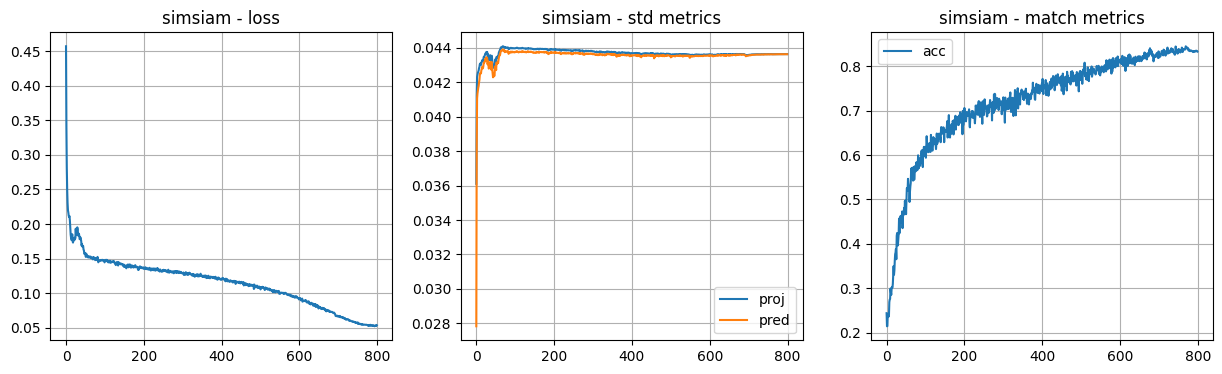

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"])
plt.grid()
plt.title(f"{loss.name} - loss")

plt.subplot(1, 3, 2)
plt.plot(history.history["proj_std"], label="proj")
if "pred_std" in history.history:
    plt.plot(history.history["pred_std"], label="pred")
plt.grid()
plt.title(f"{loss.name} - std metrics")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history["binary_accuracy"], label="acc")
plt.grid()
plt.title(f"{loss.name} - match metrics")
plt.legend()

plt.show()

## Save and Reload
 
The `ContrastiveModel` contains a set of sub-models and custom train and test steps. Consequently, the `ContrastiveModel` implements a custom save function that performs the following:
* Saves each of the sub models, including the predictor if one exists.
* A JSON file containing the serialized Loss, Metrics, and Optimizer.
* The Optimizer weighs as a npy file.
 
We also provide a custom `load_model()` function that restores the `ContrastiveModel` and supports continued training.

In [ ]:
# You can also load the trained weights from the model checkpoints
# contrastive_model.load_weights(DATA_PATH / 'models' / 'checkpoints' / f"{loss.name}_{CHECKPOINT_TIMESTAMP}")

In [ ]:
contrastive_model.save(DATA_PATH / "models" / "trained_model")

INFO:tensorflow:Assets written to: tfsim_contrastive_model/models/trained_model/assets


INFO:tensorflow:Assets written to: tfsim_contrastive_model/models/trained_model/assets


In [ ]:
del contrastive_model

In [ ]:
contrastive_model = tf.keras.models.load_model(
    DATA_PATH / "models" / "trained_model",
    custom_objects={
        "ContrastiveModel": tfsim.models.ContrastiveModel,
        "ActivationStdLoggingLayer": tfsim.layers.ActivationStdLoggingLayer,
    },
)

## Evaluation
 
This final section trains two different classifiers.
 
1. **No Pre-training**: Uses a ResNet18 model and a simple linear layer.
 
2. **Pre-trained** Uses the frozen pre-trained backbone from the ContrastiveModel and only trains the weights in the linear layer.
 
The original train data is partitioned into eval_train and eval_val splits and a simplified augmentation is applied to the training data. 
 
The models are then trained for 10 epochs and the classification accuracy is evaluated on the held out test split.

In [ ]:
TEST_EPOCHS = 10
TEST_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

In [ ]:
@tf.function
def eval_augmenter(img):
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        img, IMG_SIZE, IMG_SIZE, area_range=(0.2, 1.0)
    )
    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 255.0)

    return img

In [ ]:
eval_train_ds = tf.data.Dataset.from_tensor_slices((x_train, tf.keras.utils.to_categorical(y_train, 10)))
eval_train_ds = eval_train_ds.repeat()
eval_train_ds = eval_train_ds.shuffle(1024)
eval_train_ds = eval_train_ds.map(lambda x, y: (eval_augmenter(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.map(lambda x, y: (img_scaling(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.batch(BATCH_SIZE)
eval_train_ds = eval_train_ds.prefetch(tf.data.AUTOTUNE)

eval_val_ds = tf.data.Dataset.from_tensor_slices((x_val, tf.keras.utils.to_categorical(y_val, 10)))
eval_val_ds = eval_val_ds.repeat()
eval_val_ds = eval_val_ds.shuffle(1024)
eval_val_ds = eval_val_ds.map(lambda x, y: (img_scaling(tf.cast(x, dtype=tf.float32)), y), tf.data.AUTOTUNE)
eval_val_ds = eval_val_ds.batch(BATCH_SIZE)
eval_val_ds = eval_val_ds.prefetch(tf.data.AUTOTUNE)

eval_test_ds = tf.data.Dataset.from_tensor_slices((x_test, tf.keras.utils.to_categorical(y_test, 10)))
eval_test_ds = eval_test_ds.map(lambda x, y: (img_scaling(tf.cast(x, dtype=tf.float32)), y), tf.data.AUTOTUNE)
eval_test_ds = eval_test_ds.batch(BATCH_SIZE)
eval_test_ds = eval_test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def get_eval_model(img_size, backbone, total_steps, trainable=True, lr=1.8):
    backbone.trainable = trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs, training=trainable)
    o = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs, o)
    cosine_decayed_lr = tf.keras.experimental.CosineDecay(initial_learning_rate=lr, decay_steps=total_steps)
    opt = tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
    return model

### No Pretrain

In [ ]:
no_pt_eval_model = get_eval_model(
    img_size=IMG_SIZE,
    backbone=get_backbone(IMG_SIZE, DIM),
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=True,
    lr=1e-3,
)
no_pt_history = no_pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
87/87 [==============================] - 16s 122ms/step - loss: 2.0544 - acc: 0.2500 - val_loss: 1.7642 - val_acc: 0.3419
Epoch 2/10
87/87 [==============================] - 10s 114ms/step - loss: 1.7441 - acc: 0.3552 - val_loss: 1.6110 - val_acc: 0.4074
Epoch 3/10
87/87 [==============================] - 10s 114ms/step - loss: 1.6547 - acc: 0.3944 - val_loss: 1.5366 - val_acc: 0.4442
Epoch 4/10
87/87 [==============================] - 10s 114ms/step - loss: 1.5939 - acc: 0.4155 - val_loss: 1.4864 - val_acc: 0.4617
Epoch 5/10
87/87 [==============================] - 10s 114ms/step - loss: 1.5614 - acc: 0.4321 - val_loss: 1.4571 - val_acc: 0.4718
Epoch 6/10
87/87 [==============================] - 10s 114ms/step - loss: 1.5240 - acc: 0.4458 - val_loss: 1.4293 - val_acc: 0.4889
Epoch 7/10
87/87 [==============================] - 10s 114ms/step - loss: 1.5053 - acc: 0.4535 - val_loss: 1.4216 - val_acc: 0.4894
Epoch 8/10
87/87 [==============================] - 10s 114ms/step - 

### Pretrained

In [ ]:
pt_eval_model = get_eval_model(
    img_size=IMG_SIZE,
    backbone=contrastive_model.backbone,
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=False,
    lr=30.0,
)
pt_eval_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eval_input (InputLayer)     [(None, 32, 32, 3)]       0         
                                                                 
 resnet18sim (SimilarityMode  (None, 512)              11182784  
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 11,187,914
Trainable params: 5,130
Non-trainable params: 11,182,784
_________________________________________________________________


In [ ]:
pt_history = pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
87/87 [==============================] - 3s 23ms/step - loss: 35.6107 - acc: 0.1030 - val_loss: 25.4701 - val_acc: 0.0993
Epoch 2/10
87/87 [==============================] - 2s 21ms/step - loss: 32.7061 - acc: 0.1237 - val_loss: 30.5208 - val_acc: 0.0986
Epoch 3/10
87/87 [==============================] - 2s 21ms/step - loss: 32.7497 - acc: 0.1418 - val_loss: 27.5788 - val_acc: 0.1004
Epoch 4/10
87/87 [==============================] - 2s 21ms/step - loss: 16.5545 - acc: 0.2016 - val_loss: 8.6349 - val_acc: 0.2104
Epoch 5/10
87/87 [==============================] - 2s 21ms/step - loss: 2.4286 - acc: 0.6884 - val_loss: 0.4192 - val_acc: 0.8711
Epoch 6/10
87/87 [==============================] - 2s 21ms/step - loss: 0.3943 - acc: 0.8763 - val_loss: 0.3996 - val_acc: 0.8714
Epoch 7/10
87/87 [==============================] - 2s 21ms/step - loss: 0.3866 - acc: 0.8797 - val_loss: 0.4010 - val_acc: 0.8761
Epoch 8/10
87/87 [==============================] - 2s 21ms/step - loss: 0.3

### Comparison

In [ ]:
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 1s 41ms/step - loss: 1.3810 - acc: 0.4995
no pretrain [1.3809714317321777, 0.49950000643730164]
20/20 [==============================] - 0s 17ms/step - loss: 0.4113 - acc: 0.8748
pretrained [0.41125455498695374, 0.8748000264167786]
